In [1]:
import os
import time
import scipy
import glob
import sys

import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

import importlib
import numpy as np
import pandas as pd
import scipy.stats as spstats

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [52]:
importlib.reload(util)
util.set_sns_style(style='dark')
%matplotlib notebook

In [14]:
root_dir = '/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
experiment = '0-degree'

# src_dir = os.path.join(root_dir, experiment)
# # src_dir = '/Users/julianarhee/Documents/rutalab/data/test'
# print(src_dir)
fig_id = os.path.join(root_dir.split('/My Drive')[1], experiment)
savedir = '/Users/julianarhee/Documents/rutalab/data/gdrive/{}'.format(experiment)
savedir = savedir.replace(" ", "")
figdir = os.path.join(savedir, 'figures')
print("Saving figures to:{}    {}".format('\n', figdir))
if not os.path.exists(figdir):
    os.makedirs(figdir)

Saving figures to:
    /Users/julianarhee/Documents/rutalab/data/gdrive/0-degree/figures


In [29]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [30]:
log_files, logdf = butil.get_log_files(experiment=experiment, verbose=False, is_gdrive=True,
                        return_loginfo=True)

COMPLETE: Data copied
50 of 50 files found in: /Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Analysis/0-degree/logs


In [31]:
loginfo['experiment'].unique()
conditions=['0', 'not_reinforced']

In [32]:
strip_width=50
strip_sep=200
is_csv = False
df0_all = butil.load_combined_df(log_files=log_files, logdf=logdf, 
                                is_csv=is_csv, experiment=experiment, 
                                savedir=savedir, save_errors=True, create_new=True,
                                parse_filename=False, remove_invalid=True, process=True)
df0_all = df0_all.rename(columns={'Unnamed: 0': 'frame'})
condition_list = df0_all['condition'].unique()
print("Found {} conditions:".format(len(condition_list)))
for c in condition_list:
    print(c)

Processing 50 tracking files.
[WARNING] 08192020-203059_0degOdor: Found bad skips, removing 18147 of 23593 samples.
--> found bad skips in FTs, check: 08192020-203059_0degOdor
[WARNING] 08242020-211008_0degOdor: Found bad skips, removing 92 of 43154 samples.
--> found bad skips in FTs, check: 08242020-211008_0degOdor
[WARNING] 08252020-021424_0degOdor: Found bad skips, removing 31296 of 60724 samples.
--> found bad skips in FTs, check: 08252020-021424_0degOdor
Correcting experiment conditions: 0-degree
Saving combined df to: /Users/julianarhee/Documents/rutalab/data/gdrive/0-degree
Found 3 conditions:
0
not_reinforced
reinforced


In [41]:
curr_conds = ['0', 'not_reinforced']
curr_geno = ['CS']

df0 = df0_all[df0_all['condition'].isin(curr_conds) \
          & (df0_all['genotype'].isin(curr_geno))].copy()


In [70]:
d_list=[]
odor_borders_fp={}
for trial_id, df_ in df0.groupby('trial_id'):
    df1, new_borders = butil.check_entryside_and_flip(df_, strip_width=strip_width) #,
    oparams = butil.get_odor_params(df1) #[df1['condition']==cond])
    df1 = df1[df1['time']>=oparams['odor_start_time']].copy()
    if trial_id=='20220628_HDC_sytjGCaMP7f_Fly1_et':
        d_list.append(df1[df1['boutnum']>=4])
    else:
        d_list.append(df1)
    odor_borders_fp[trial_id] = new_borders
df_fp = pd.concat(d_list)

... Using default odor min/max, animal 09082020-124318_Fly7_CantonS_002 did not move in odor


In [66]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [67]:
df_fp = butil.normalize_position(df_fp)

KeyboardInterrupt: 

In [79]:

def zero_start_position(b_):
    b_['ft_posx_start0'] = b_['ft_posx'] - b_['ft_posx'].iloc[0]
    b_['ft_posy_start0'] = b_['ft_posy'] - b_['ft_posy'].iloc[0]
    return b_

def normalize_position(b_):
    b_['ft_posx_norm'] = util.convert_range(b_['ft_posx_start0'], newmin=0, newmax=1)
    b_['ft_posy_norm'] = util.convert_range(b_['ft_posy_start0'], newmin=0, newmax=1)
    return b_

In [80]:
df_fp = df_fp.groupby(['trial_id', 'boutnum'], group_keys=False).apply(zero_start_position)

In [81]:
df_fp = df_fp.groupby(['trial_id', 'boutnum'], group_keys=False).apply(normalize_position)

In [48]:
trial_ids = df0['trial_id'].unique()
len(trial_ids)

24

In [49]:
figdir

'/Users/julianarhee/Documents/rutalab/data/gdrive/0-degree/figures'

<IPython.core.display.Javascript object>


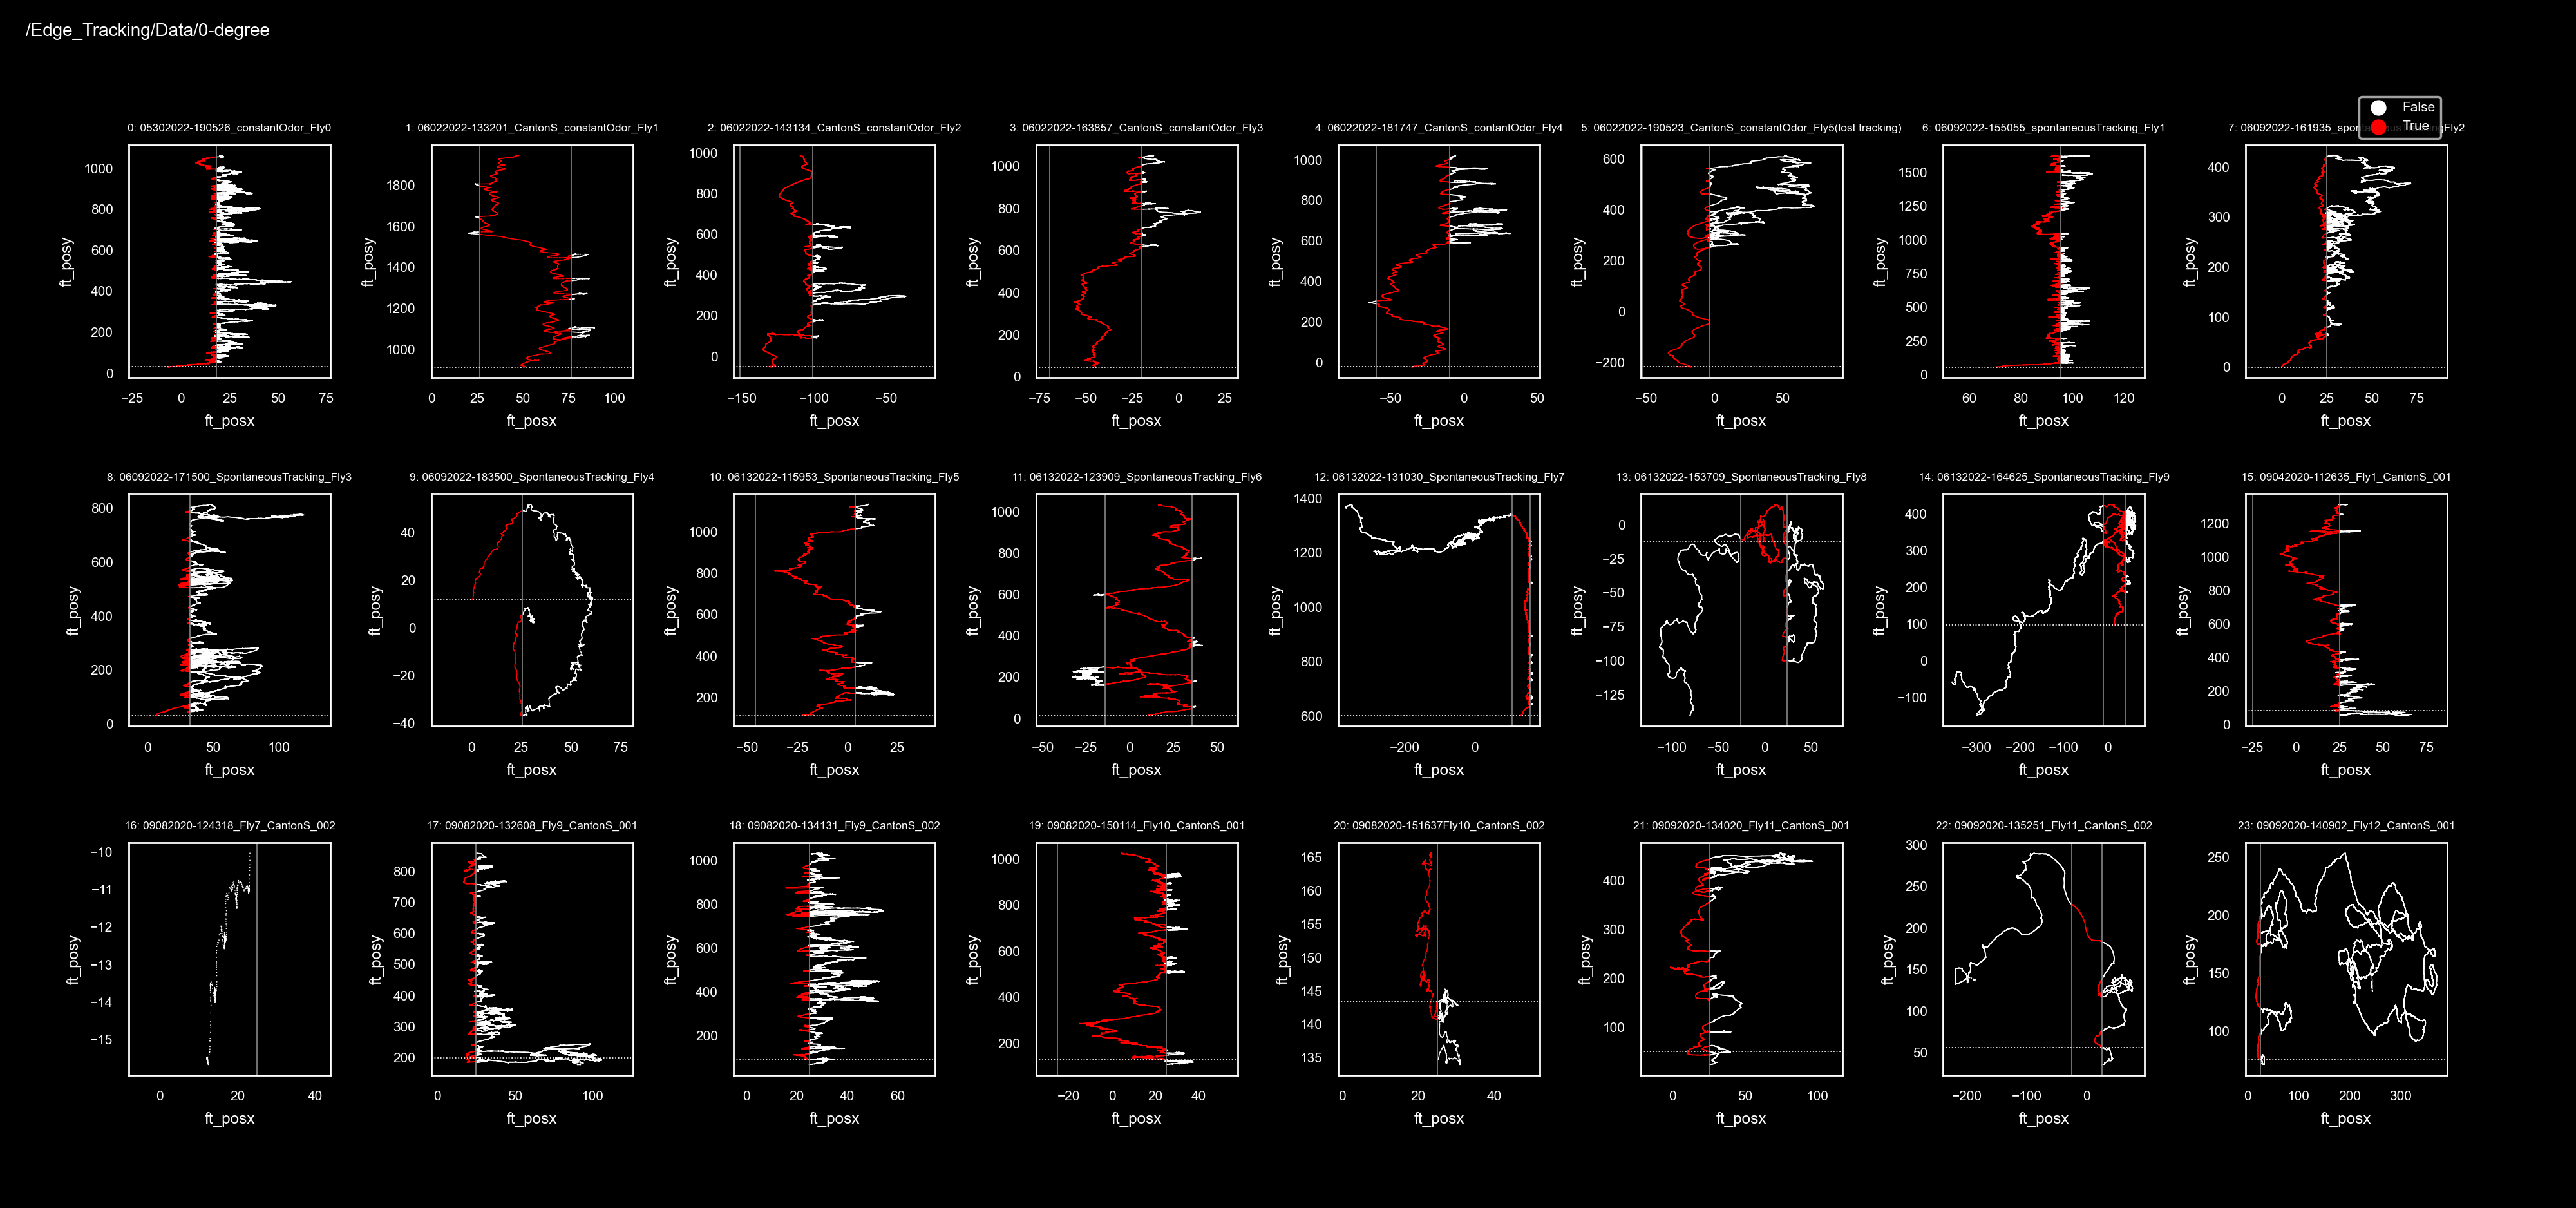

/Users/julianarhee/Documents/rutalab/data/gdrive/0-degree/figures inout_traj_all_flies


In [61]:
nc=8; nr=3;
fig, axn = pl.subplots(nr, nc, figsize=(nc*2, nr*2.5))
for ai, (ax, (trial_id, df)) in enumerate(zip(axn.flat, df_fp.groupby('trial_id'))):
    plotb = df[(df['boutnum']>=2)].copy() #* (df['boutnum'].isin(longbouts))].copy()
    strip_borders = butil.find_strip_borders(df, strip_width=strip_width, strip_sep=strip_sep,
                                             is_grid=True, get_all_borders=True)
    butil.plot_trajectory(plotb, ax=ax,odor_bounds=strip_borders, markersize=0.25)
    if ai==(nc-1):
        ax.legend(bbox_to_anchor=(1,1), loc='lower right', fontsize=6)
    else:
        ax.legend_.remove()
    ax.set_title('{}: {}'.format(ai, trial_id), fontsize=5)
for ax in axn.flat[len(trial_ids):]:
    ax.axis('off')
pl.subplots_adjust(wspace=0.5, hspace=0.5, right=0.95, left=0.05)
util.label_figure(fig, fig_id)

figname = 'inout_traj_all_flies'
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))
print(figdir, figname)

<IPython.core.display.Javascript object>


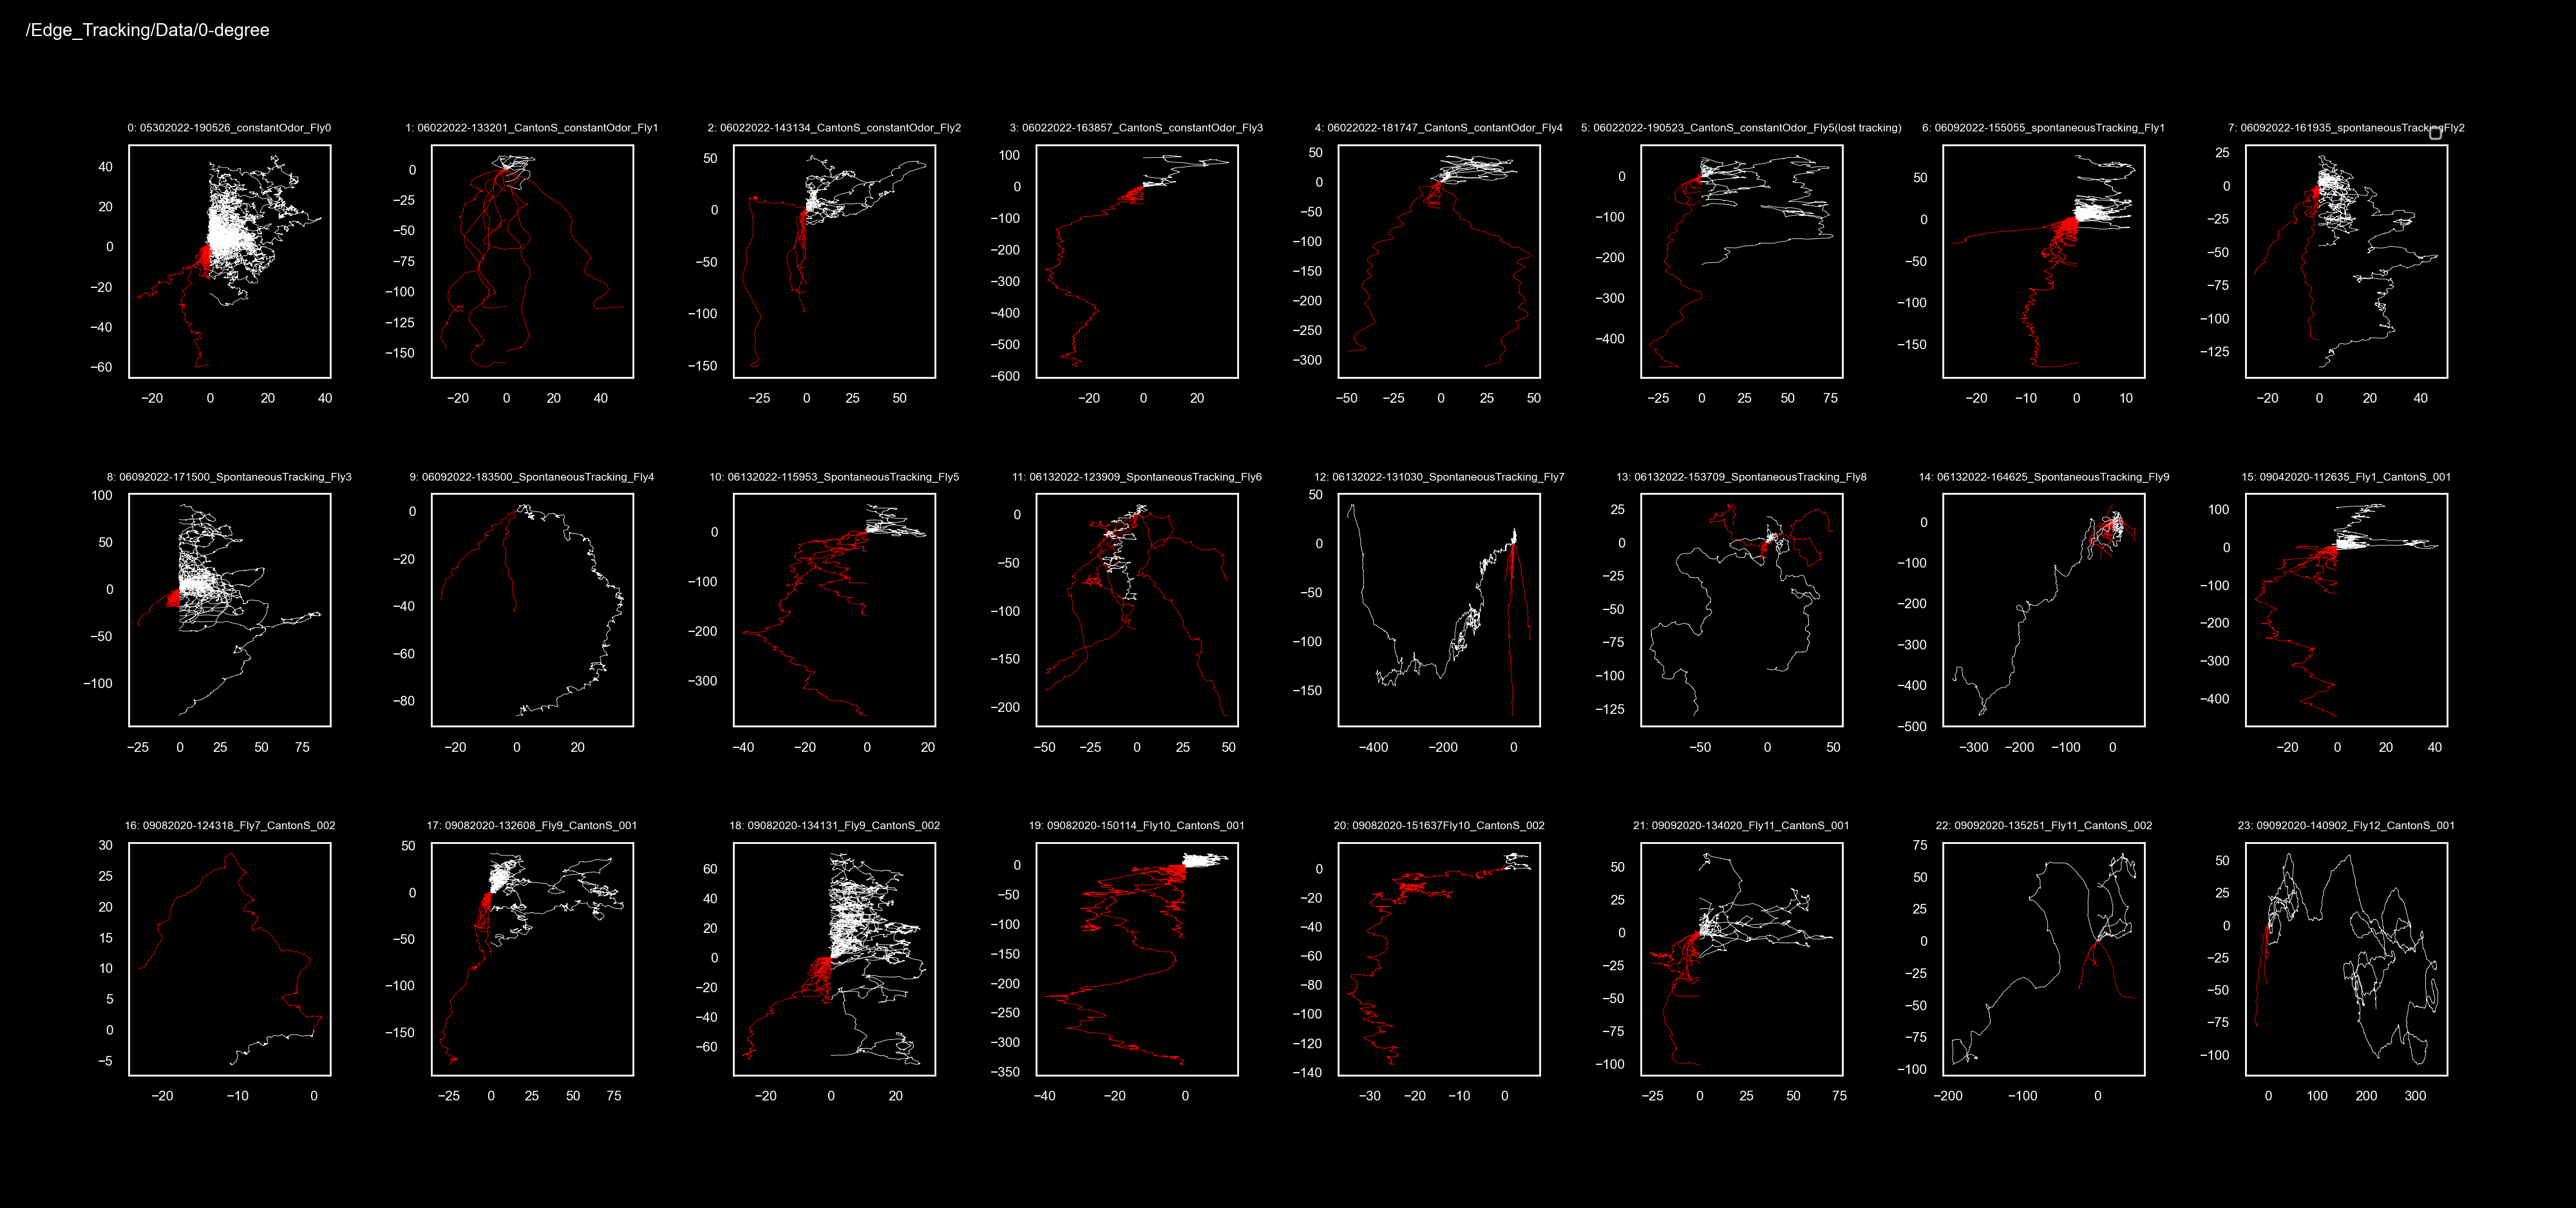

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [83]:
nc=8; nr=3;
fig, axn = pl.subplots(nr, nc, figsize=(nc*2, nr*2.5))
for ai, (ax, (trial_id, df)) in enumerate(zip(axn.flat, df_fp.groupby('trial_id'))):
    plotb = df[(df['boutnum']>=2)].copy() #* (df['boutnum'].isin(longbouts))].copy()
    currd = plotb[~plotb['instrip']].copy()
#     norm_ = mpl.colors.Normalize(vmin=currd['boutnum'].unique().min(), 
#                                  vmax=currd['boutnum'].unique().max())
#     cmap_ = mpl.cm.viridis
#     cols = [cmap_(norm_(v)) for v in currd['boutnum'].unique()]
    for bnum, b_ in currd.groupby('boutnum'):
        inbout = df[df['boutnum']==bnum-1].copy()
        ax.plot(b_['ft_posx_start0'], b_['ft_posy_start0'], 
            lw=0.25, color='w')
        ax.plot(inbout['ft_posx_start0']-inbout['ft_posx_start0'].iloc[-1], 
                inbout['ft_posy_start0']-inbout['ft_posy_start0'].iloc[-1],
            lw=0.25, color='r')
    if ai==(nc-1):
        ax.legend(bbox_to_anchor=(1,1), loc='lower right', fontsize=6)
    else:
        if ax.legend_ is not None:
            ax.legend_.remove()
    ax.set_title('{}: {}'.format(ai, trial_id), fontsize=5)
for ax in axn.flat[len(trial_ids):]:
    ax.axis('off')
pl.subplots_adjust(wspace=0.5, hspace=0.5, right=0.95, left=0.05)
util.label_figure(fig, fig_id)

figname = 'inout_traj_normed_all_flies'
pl.savefig(os.path.join(figdir, '{}.png'.format(figname)))

In [119]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [177]:
trial_id_ixs = [0, 6,7, 8, 12, 17, 18]
incl_trial_ids = trial_ids[trial_id_ixs]
incl_trial_ids

array(['05302022-190526_constantOdor_Fly0',
       '06092022-155055_spontaneousTracking_Fly1',
       '06092022-161935_spontaneousTrackingFly2',
       '06092022-171500_SpontaneousTracking_Fly3',
       '06132022-131030_SpontaneousTracking_Fly7',
       '09082020-132608_Fly9_CantonS_001',
       '09082020-134131_Fly9_CantonS_002'], dtype=object)

In [185]:
df = df_fp[df_fp['trial_id'].isin(incl_trial_ids)].copy()
#mdf = metrics[metrics['trial_id'].isin(incl_trial_ids)].copy()
if not all(df.groupby(['trial_id'])['instrip'].last()):
    last_is_outbout = df.groupby(['trial_id'])['instrip'].last()
    d_list=[]
    for trial_id, df_ in df.groupby('trial_id'):
        if trial_id in last_is_outbout[last_is_outbout==False].index.tolist():
            df_.drop(df_[(df_['instrip']==False) 
                   & (df_['boutnum']==df_['boutnum'].max())].index, inplace=True)
        d_list.append(df_)
    df = pd.concat(d_list)
assert all(df.groupby(['trial_id'])['instrip'].last())


In [186]:
heading_vars = [c for c in df_fp.columns if 'phase' in c or 'heading' in c]
group_vars=['fly_id', 'condition' , 'boutnum', 'trial_id']
metrics = df.groupby(['trial_id', 'boutnum'])\
            .apply(butil.calculate_bout_metrics, group_vars=group_vars,
                   heading_vars=heading_vars).unstack().reset_index()

In [188]:
trial_id = incl_trial_ids[0]
print(trial_id)
df_=df[df['trial_id']==trial_id].copy()
df_.shape

05302022-190526_constantOdor_Fly0


(84548, 45)

In [228]:
xvar='ft_posx_start0'
yvar='ft_posy_start0'


In [229]:
max_nframes = mdf['n_frames'].max()
d_list=[]
for (trial_id, bnum), b_ in df.groupby(['trial_id', 'boutnum']):
    px = np.pad(b_[xvar].values, (0, int(max_nframes-len(b_))), 'constant', constant_values=np.nan)
    py = np.pad(b_[yvar].values, (0, int(max_nframes-len(b_))), 'constant', constant_values=np.nan)
    d_ = pd.DataFrame({
                  'boutnum': [bnum]*len(px),
                  'trial_id': [trial_id]*len(px),
                   xvar: px, 
                   yvar: py, 
                  'ix': np.arange(0, len(px)),
                  'instrip': [b_['instrip'].unique()[0]]*len(px)})
    d_list.append(d_)
upsamp_bouts = pd.concat(d_list)

In [221]:
upsamp_bouts.groupby(['trial_id']).apply(np.nanmean)

trial_id
05302022-190526_constantOdor_Fly0           2494.136263
06092022-155055_spontaneousTracking_Fly1    2529.276850
06092022-161935_spontaneousTrackingFly2     2448.640309
06092022-171500_SpontaneousTracking_Fly3    2474.734685
06132022-131030_SpontaneousTracking_Fly7    2518.795219
09082020-132608_Fly9_CantonS_001            2452.129981
09082020-134131_Fly9_CantonS_002            2458.058580
dtype: float64

In [232]:
trial_id = trial_ids[6]
print(trial_id)

06092022-155055_spontaneousTracking_Fly1


In [230]:
for trial_id, df_ in upsamp_bouts.groupby('trial_id'):
    df_

In [242]:
df_.groupby('boutnum')['instrip'].unique()

boutnum
2       [True]
3      [False]
4       [True]
5      [False]
6       [True]
        ...   
154     [True]
155    [False]
156     [True]
157    [False]
158     [True]
Name: instrip, Length: 157, dtype: object

<IPython.core.display.Javascript object>


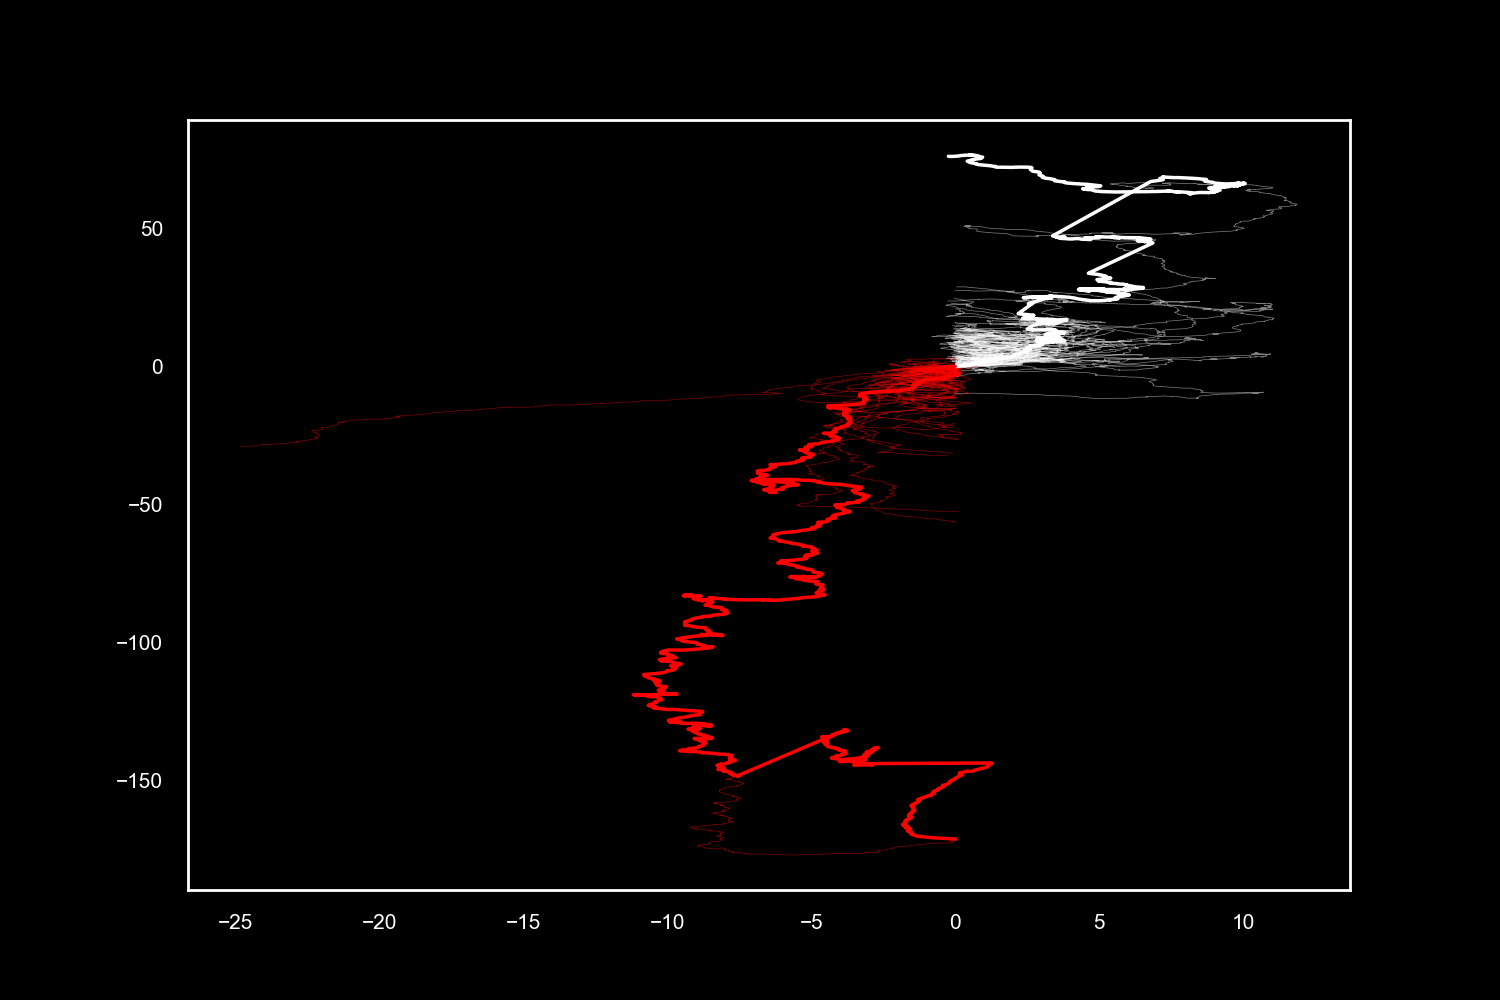

In [262]:
df_ = upsamp_bouts[upsamp_bouts['trial_id']==trial_id].copy()

fig, ax = pl.subplots()
for bnum, b_ in df_[~df_['instrip']].groupby('boutnum'):
    inbout = df_[df_['boutnum']==bnum-1].copy()
    ax.plot(b_['ft_posx_start0'], b_['ft_posy_start0'], 
        lw=0.2, color='w', alpha=0.5)
    ax.plot(inbout['ft_posx_start0']-inbout['ft_posx_start0'].dropna().iloc[-1], 
            inbout['ft_posy_start0']-inbout['ft_posy_start0'].dropna().iloc[-1],
        lw=0.2, color='r', alpha=0.5)
    
avgx = df_.groupby(['instrip', 'ix'])[xvar].mean().reset_index()
avgy = df_.groupby(['instrip', 'ix'])[yvar].mean().reset_index()

ax.plot(avgx[~avgx['instrip']]['ft_posx_start0'], avgy[~avgy['instrip']]['ft_posy_start0'], 
        lw=1, color='w', alpha=1)
ax.plot(avgx[avgx['instrip']]['ft_posx_start0']-avgx[avgx['instrip']]['ft_posx_start0'].dropna().iloc[-1],
        avgy[avgy['instrip']]['ft_posy_start0']-avgy[avgy['instrip']]['ft_posy_start0'].dropna().iloc[-1],
        
        lw=1, color='r', alpha=1)

In [253]:
df_.groupby(['instrip', 'ix'])[xvar].mean().reset_index()


,instrip,ix,ft_posx_start0
0,False,0,0.000000
1,False,1,0.093665
2,False,2,0.179393
3,False,3,0.266363
4,False,4,0.341327
...,...,...,...
30319,True,15157,NaN
30320,True,15158,NaN
30321,True,15159,NaN
30322,True,15160,NaN


In [247]:
inbout

,boutnum,trial_id,ft_posx_start0,ft_posy_start0,ix,instrip
0,156,06092022-155055_spontaneousTracking_Fly1,0.000000,0.000000,0,True
1,156,06092022-155055_spontaneousTracking_Fly1,-0.144794,0.069116,1,True
2,156,06092022-155055_spontaneousTracking_Fly1,-0.280867,0.153564,2,True
3,156,06092022-155055_spontaneousTracking_Fly1,-0.384546,0.181001,3,True
4,156,06092022-155055_spontaneousTracking_Fly1,-0.515582,0.208934,4,True
...,...,...,...,...,...,...
15157,156,06092022-155055_spontaneousTracking_Fly1,NaN,NaN,15157,True
15158,156,06092022-155055_spontaneousTracking_Fly1,NaN,NaN,15158,True
15159,156,06092022-155055_spontaneousTracking_Fly1,NaN,NaN,15159,True
15160,156,06092022-155055_spontaneousTracking_Fly1,NaN,NaN,15160,True


<IPython.core.display.Javascript object>


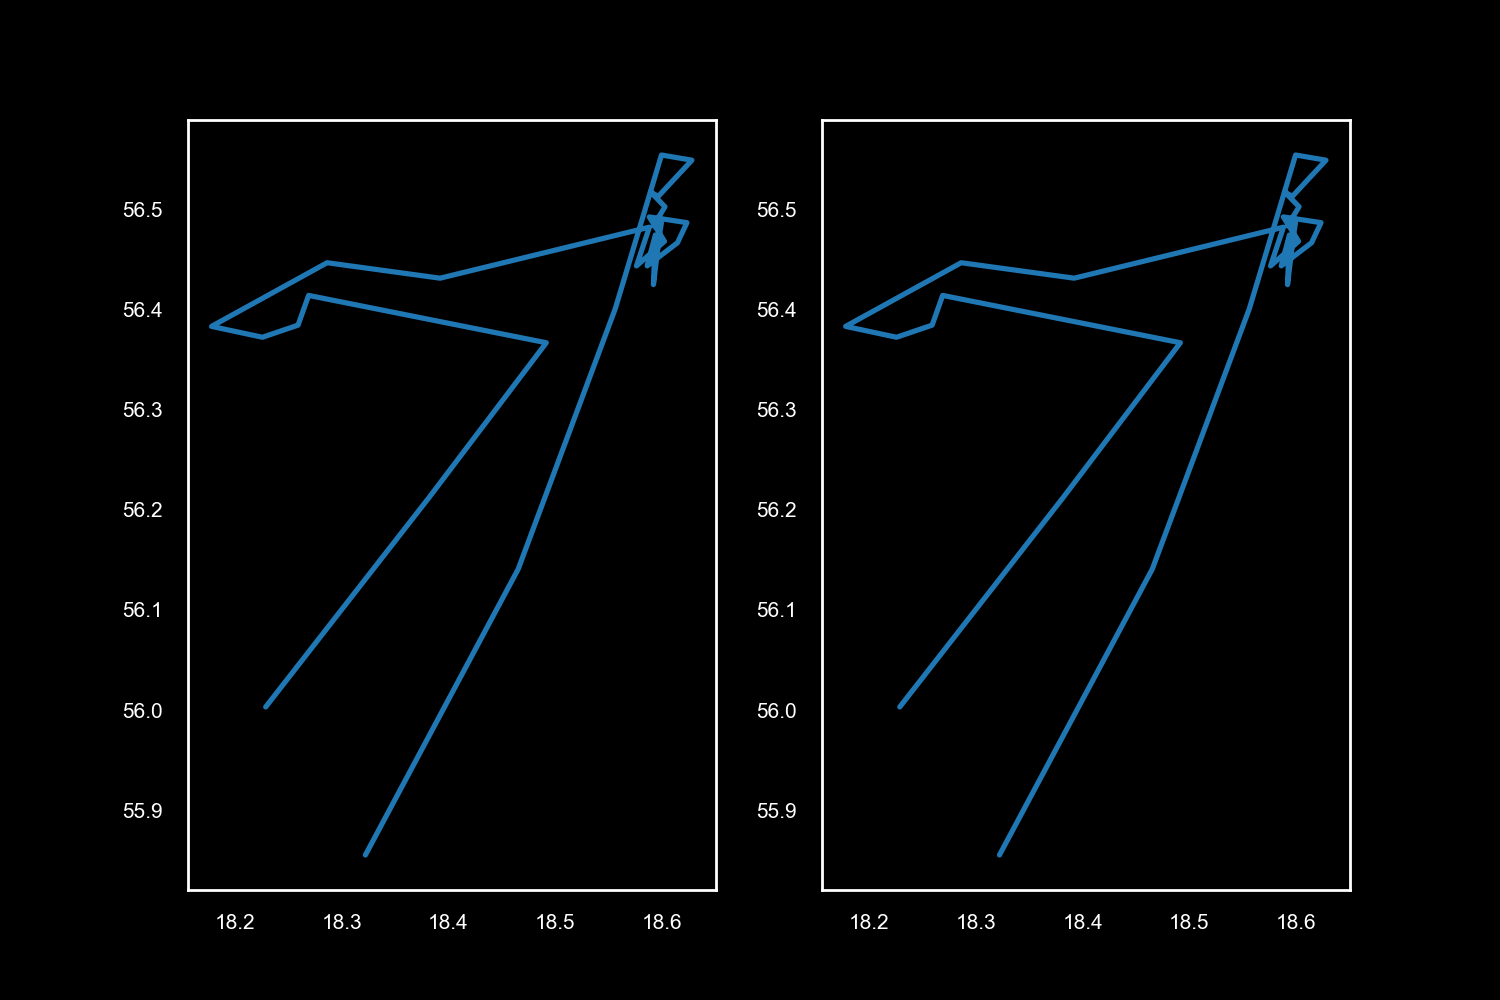

In [208]:
fig, axn = pl.subplots(1, 2)
px = np.pad(b_['ft_posx'].values, (0, int(max_nframes-len(b_))), 'constant', constant_values=np.nan)
py = np.pad(b_['ft_posy'].values, (0, int(max_nframes-len(b_))), 'constant', constant_values=np.nan)

axn[0].plot(b_['ft_posx'].values, b_['ft_posy'].values)

axn[1].plot(px, py)




In [207]:
padded_

array([18.32203346, 18.46542458, 18.55649629, ...,  0.        ,
        0.        ,  0.        ])